# Does it Correlate? Analysis Steps

## Dataset Loading and Initial Preparation

**HINTS**
### Pre-processing Hint
- Use `.str` accessor on `pandas.Series` for string manipulation.
- `.str.rstrip()` can help remove unwanted characters from the end of strings.

### Example Pre-processing Code
```python
simd["EduUniver"] = simd["EduUniver"].str.rstrip('%').astype(float)


1. **Load the Dataset**  
   Load the complete dataset into your Jupyter Notebook without filtering for Glasgow.

Let's define some necessary functions:

In [ ]:
import zipfile
import shutil
import requests
import esda
import geopandas as gpd
import matplotlib.pyplot as plt
import mgwr
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
from libpysal import graph
import os
from os.path import join, exists
from threading import Timer
from pathlib import Path
from sklearn.preprocessing import StandardScaler




### Downloading and Unzipping Data

- **Link:** [SIMD Data](https://maps.gov.scot/ATOM/shapefiles/SG_SIMD_2020.zip)

The downloaded file will be saved to the following destination:

- **Destination:** `data/SG_SIMD_2020.zip`

Defined two functions: `download_file`  to download the data and the `unzip_file` function to unzip the downloaded file.
```

In [8]:
def download_file(path, output_path, temporal=False, timer=60):
        print(f"Downloading {path} to {output_path}")
        with requests.get(path, stream=True) as r:
            r.raise_for_status()
            if exists(output_path):
                pass
            else:
                with open(output_path, "wb") as f:
                    shutil.copyfileobj(r.raw, f)
        if temporal:
            try:
                Timer(timer, lambda: Path(output_path).unlink()).start()
            except:
                print(f'Failed to remove temporal file {output_path}')

def unzip_file(zip_file, output_folder, overwrite=False):
        if not os.path.isfile(zip_file):
            raise FileNotFoundError(f"The file '{zip_file}' does not exist.")
        
        with zipfile.ZipFile(zip_file, "r") as to_extract:
            zip_files = to_extract.namelist()
            # flag if any files are missing
            files_missing = False
            
            for zip_file_name in zip_files:
                extracted_file_path = os.path.join(output_folder, zip_file_name)
                if not os.path.exists(extracted_file_path):
                    files_missing = True
                    break  
            
            if files_missing or overwrite:
                to_extract.extractall(output_folder)

#### Download and unzip the SIMD data

In [9]:
link = r'https://maps.gov.scot/ATOM/shapefiles/SG_SIMD_2020.zip'
dest = r'data/SG_SIMD_2020.zip'
download_file(link, dest)
unzip_file(dest, r'data/SG_SIMD_2020')
file = r'data/SG_SIMD_2020/SG_SIMD_2020.shp'

In [10]:
gdf_simd = gpd.read_file(file)
gdf_simd.dtypes

c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\pyogrio\core.py:26: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


DataZone        object
DZName          object
LAName          object
SAPE2017         int64
WAPE2017         int64
Rankv2           int64
Quintilev2       int64
Decilev2         int64
Vigintilv2       int64
Percentv2        int64
IncRate         object
IncNumDep        int64
IncRankv2      float64
EmpRate         object
EmpNumDep        int64
EmpRank        float64
HlthCIF          int64
HlthAlcSR        int64
HlthDrugSR       int64
HlthSMR          int64
HlthDprsPc      object
HlthLBWTPc      object
HlthEmergS       int64
HlthRank         int64
EduAttend       object
EduAttain      float64
EduNoQuals       int64
EduPartici      object
EduUniver       object
EduRank          int64
GAccPetrol     float64
GAccDTGP       float64
GAccDTPost     float64
GAccDTPsch     float64
GAccDTSsch     float64
GAccDTRet      float64
GAccPTGP       float64
GAccPTPost     float64
GAccPTRet      float64
GAccBrdbnd      object
GAccRank         int64
CrimeCount       int64
CrimeRate        int64
CrimeRank  


2. **Variable Exploration**  
   Explore the effect of the following variables on the target:
   - Proportion of youths entering university (`EduUniver`)
   - Crime rate (`CrimeRate`)
   - Hospital stays related to alcohol use (`HlthAlcSR`)
   - Hospital stays related to drug use (`HlthDrugSR`)
   - Mortality (`HlthSMR`)

In [11]:
gdf_simd['EduUniver'].head(100)
gdf_simd['EduUniver'] = gdf_simd['EduUniver'].astype(str).str.rstrip('%').astype(float)
gdf_simd['CrimeRate'].dtypes
gdf_simd['HlthAlcSR'].dtypes
gdf_simd['HlthDrugSR'].dtypes
gdf_simd['HlthSMR'].dtypes

dtype('int64')

In [12]:
gdf_simd['Rankv2'].describe()

count    6976.000000
mean     3488.500000
std      2013.942071
min         1.000000
25%      1744.750000
50%      3488.500000
75%      5232.250000
max      6976.000000
Name: Rankv2, dtype: float64

In [13]:
gdf_simd['EduUniver'].describe()


count    6976.000000
mean        9.193234
std         6.278158
min         0.000000
25%         5.000000
50%         8.000000
75%        12.000000
max        82.000000
Name: EduUniver, dtype: float64

#### All cols are integers or float

3. **Ensure Correct Data Types**  
   - Confirm that all columns are numeric (`float` or `int`).
   - Remove unwanted characters (e.g., `%`) and convert strings to numeric types.

In [37]:
gdf_simd_subset = gdf_simd[['DataZone', 'Rankv2', 'EduUniver', 'CrimeRate', 'HlthAlcSR', 'HlthDrugSR', 'HlthSMR', 'LAName', 'geometry']]
indep_vars = gdf_simd_subset.columns.drop(['DataZone', 'Rankv2', 'geometry'])

In [15]:
formula = f"Rankv2 ~ {' + '.join(indep_vars)}"
formula

'Rankv2 ~ EduUniver + CrimeRate + HlthAlcSR + HlthDrugSR + HlthSMR'

4. **Create a standard OLS regression predicting "Rankv2" based on these 5 variables.**
    - What can you tell about them?
    - How good is the model?

In [16]:
ols = sm.ols(formula, data=gdf_simd_subset).fit()

In [17]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rankv2   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     2872.
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:53:40   Log-Likelihood:                -59069.
No. Observations:                6976   AIC:                         1.181e+05
Df Residuals:                    6970   BIC:                         1.182e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4278.0717     46.173     92.654      0.000    4187.559    4368.584
EduUniver    117.6247      2.423     48.545      0.000     112.875     122.375
CrimeRate     -0.3148      0.038     -8.242      0.000      -0.390      -0.240
HlthAlcSR     -5.4895      0.200    -27.485      0.000      -5.881      -5.098
HlthDrugSR    -3.0847      0.141    -21.800      0.000      -3.362      -2.807
HlthSMR       -9.1912      0.347    -26.512      0.000      -9.871      -8.512
==============================================================================
Omnibus:                      698.868   Durbin-Watson:                   1.396
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2099.309
Skew:                           0.531   Prob(JB):                         0.00
Kurtosis:                       5.469   Cond. No.                     1.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
gdf_simd_subset.explore(columns='EduUniver', cmap='viridis', legend=True)

In [18]:
predicted = ols.predict(gdf_simd_subset)
predicted.head()

0    6872.347552
1    3802.481347
2    5649.903475
3    5722.857555
4    4205.317732
dtype: float64

5. **Compare the prediction with the original data on a map.**
    - Can you spot the difference?

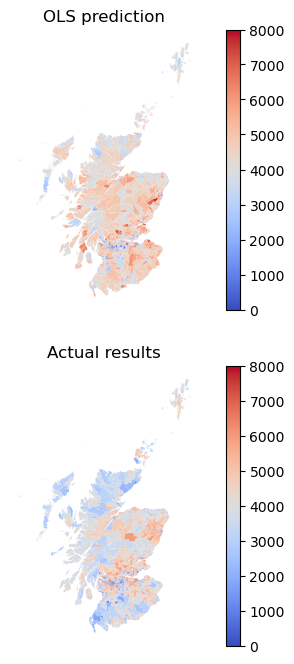

In [19]:
f, axs = plt.subplots(2, 1, figsize=(7, 8))
gdf_simd_subset.plot(
    predicted, legend=True, cmap="coolwarm", vmin=0, vmax=8000, ax=axs[0]
)
gdf_simd_subset.plot(
    "Rankv2", legend=True, cmap="coolwarm", vmin=0, vmax=8000, ax=axs[1]
)
axs[0].set_title("OLS prediction")
axs[1].set_title("Actual results")

axs[0].set_axis_off()
axs[1].set_axis_off()

6. **Plot residuals.**
    - Is there a geographical pattern?
    - Overestimates sparsely populated areas, overestimates large city centres and densely populated areas

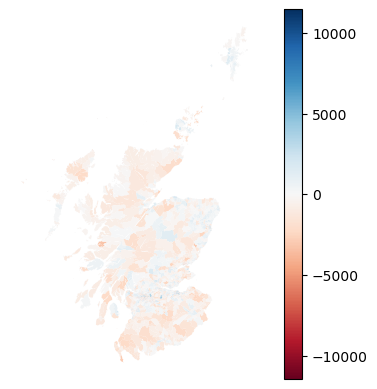

In [ ]:
gdf_simd_subset.loc[:, "residual"] = ols.resid
max_residual = ols.resid.abs().max()
ax = gdf_simd_subset.plot(
    "residual", legend=True, cmap="RdBu", vmin=-max_residual, vmax=max_residual
)
ax.set_axis_off()

In [ ]:
gdf_simd_subset.explore(
    column="residual",
    cmap="RdBu",    
    legend=True,    
    vmin=-max_residual,     
    vmax=max_residual      
)

7. **Check for geographical patterns in residuals using the spatial autocorrelation analysis of your choice.**


In [32]:
contiguity_r = graph.Graph.build_contiguity(gdf_simd_subset).transform("r")
gdf_simd_subset.loc[:, "residual_lag"] = contiguity_r.lag(gdf_simd_subset["residual"])

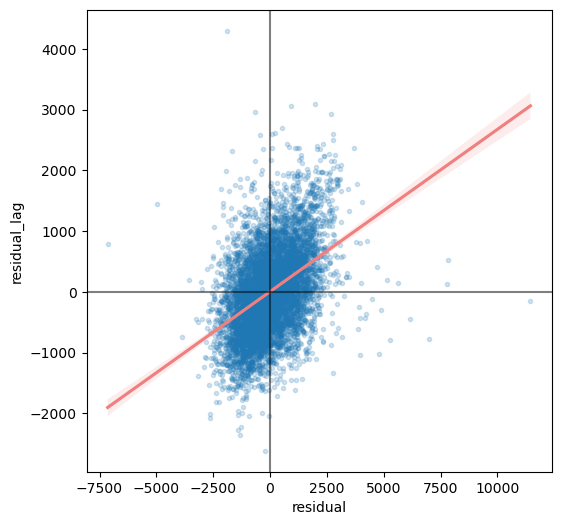

In [33]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="residual",
    y="residual_lag",
    data=gdf_simd_subset,
    marker=".",
    scatter_kws={"alpha": 0.2},
    line_kws=dict(color="lightcoral")
)
plt.axvline(0, c="black", alpha=0.5)
plt.axhline(0, c="black", alpha=0.5);

In [ ]:
lisa = esda.Moran_Local(gdf_simd_subset['residual'], contiguity_r)

In [ ]:
lisa.explore(gdf_simd_subset, prefer_canvas=True, tiles="CartoDB Positron")

8. **Create another OLS model and include local authority "LAName" in the formula.**
    - Are there significant spatial fixed effects? 
    - Did the model improve? How much?


In [38]:
formula_fe = f"Rankv2 ~ {' + '.join(indep_vars)} + LAName - 1" 
ols_fe = sm.ols(formula_fe, data=gdf_simd_subset).fit()

In [39]:
fixed_effects = ols_fe.params.filter(like="LAName")
fixed_effects.head()

LAName[Aberdeen City]        4873.980527
LAName[Aberdeenshire]        4738.425416
LAName[Angus]                4044.819664
LAName[Argyll and Bute]      4094.803576
LAName[City of Edinburgh]    4793.673551
dtype: float64

In [42]:
fixed_effects.describe()

count      32.000000
mean     4242.590717
std       329.972415
min      3773.250446
25%      4007.709695
50%      4189.634066
75%      4490.440709
max      4886.594781
dtype: float64

In [40]:
fixed_effects.index = fixed_effects.index.str.strip(
    "LAName["
).str.strip("]")
fixed_effects.head()

berdeen City         4873.980527
berdeenshire         4738.425416
ngus                 4044.819664
rgyll and Bute       4094.803576
City of Edinburgh    4793.673551
dtype: float64

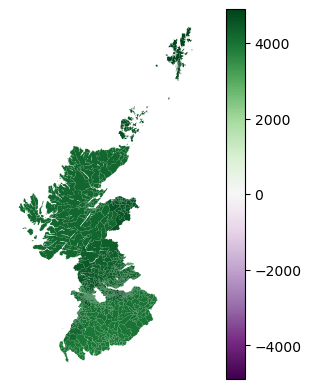

In [41]:
max_effect = fixed_effects.abs().max()
gdf_simd_subset.merge(
    fixed_effects.to_frame("fixed_effect"),
    left_on="LAName",
    right_index=True,
    how="left",
).plot(
    "fixed_effect", legend=True, vmin=-max_effect, vmax=max_effect, cmap="PRGn"
).set_axis_off() # v grafu jsou zobrazeny fixni efekty pro jednotlive okresy 

9. **Create geographically weighted regression using the set of variables from the first model.**
    - Use adaptive kernel with bandiwdth=150 or figure out the optimal adaptive bandwidth yourself
    - Is the model better than those before?

In [43]:
coords = gdf_simd_subset.centroid.get_coordinates().values


In [60]:
y = gdf_simd_subset[f"Rankv2"].values.reshape(-1, 1)
X = gdf_simd_subset[indep_vars[1:-1]].values # drop first and last columns


In [ ]:
# Standardize the variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

fixed_bandwidth = mgwr.gwr.GWR(
    coords, y, X_scaled, bw=150, fixed=True, name_x=indep_vars[1:]
)
results = fixed_bandwidth.fit()

c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\mgwr\gwr.py:802: RuntimeWarning: divide by zero encountered in scalar divide
  return (self.resid_ss / (self.n - self.tr_S))
c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\mgwr\gwr.py:676: RuntimeWarning: invalid value encountered in multiply
  return cov * self.scale


10. **Explore GWR results.**
    - What is the distribution of local R2? Can you say anything about the significance of individual variables?